#**스마트폰 센서 데이터 기반 모션 분류**
# 단계1 : 탐색적 데이터 분석

## 0.미션

### (1) 미션1
수많은 feature들을 모두 살펴보는 것은 과도한 시간과 노력이 필요합니다. 그래서 여러분은 **선택과 집중**을 해야 합니다.
* 1) **기본 모델을 생성**한 후 **변수 중요도**를 구합니다.   
    * random forest 알고리즘 사용을 권장합니다.
* 2) **중요한 feature와 중요하지 않은 feature 상위 N개를 선정**하고, 이들을 대상으로 EDA 수행.


### (2) 미션2
다음의 case에 맞게 feature 및 feature 그룹 중요도를 기반으로 탐색적 데이터 분석을 수행하시오.
* Target을 **정적/동적 행동**으로 구분
    * 6개의 행동은 2개의 그룹(정적행동, 동적행동)으로 나뉩니다.  
    * 어떤 feature(혹은 feature 그룹)이 2개 class 그룹(정적행동, 동적행동)를 구분하는데 중요한지를 찾아보고 탐색해봅시다.


## 1.환경설정

* 세부 요구사항
    - 경로 설정 : 구글콜랩
        * 구글 드라이브 바로 밑에 project3 폴더를 만들고,
        * 데이터 파일을 복사해 넣습니다.
    - 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
        * 필요하다고 판단되는 라이브러리를 추가하세요.


### (1) 경로 설정

* 구글 드라이브 연결

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
path = '/content/drive/MyDrive/project3/'

### (2) 라이브러리 설치 및 불러오기

* 라이브러리 로딩

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import joblib

from sklearn.ensemble import RandomForestClassifier
!pip install koreanize_matplotlib -q
import koreanize_matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 22.5 MB/s eta 0:00:00


* 제공 함수 생성
    * 변수 중요도를 시각화할 수 있는 함수를 제공합니다.
    * 입력 :
        * importance : 트리모델의 변수 중요도(예: model.feature_importances_)
        * names : 변수 이름 목록(예 : x_train.columns
        * result_only  : 변수 중요도 순으로 데이터프레임만 return할지, 그래프도 포함할지 결정. False이면 결과 데이터프레임 + 그래프
        * topn : 중요도 상위 n개만 표시. all 이면 전체.
    * 출력 :
        * 중요도 그래프 : 중요도 내림차순으로 정렬
        * 중요도 데이터프레임 : 중요도 내림차순으로 정렬

In [4]:
# 변수의 특성 중요도 계산하기
def plot_feature_importance(importance, names, result_only = False, topn = 'all'):
    feature_importance = np.array(importance)
    feature_name = np.array(names)

    data={'feature_name':feature_name,'feature_importance':feature_importance}
    fi_temp = pd.DataFrame(data)

    #변수의 특성 중요도 순으로 정렬하기
    fi_temp.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    fi_temp.reset_index(drop=True, inplace = True)

    if topn == 'all' :
        fi_df = fi_temp.copy()
    else :
        fi_df = fi_temp.iloc[:topn]

    #변수의 특성 중요도 그래프로 그리기
    if result_only == False :
        plt.figure(figsize=(10,20))
        sns.barplot(x='feature_importance', y='feature_name', data = fi_df)

        plt.xlabel('importance')
        plt.ylabel('feature name')
        plt.grid()

    return fi_df

### (3) 데이터 불러오기

* 주어진 데이터셋
    * data01_train.csv : 학습 및 검증용
    * data01_test.csv : 테스트용
    * feature.csv : feature 이름을 계층구조로 정리한 데이터

* 세부 요구사항
    * 칼럼 삭제 : data01_train.csv와 data01_test.csv 에서 'subject' 칼럼은 불필요하므로 삭제합니다.

In [5]:
train = pd.read_csv(path + 'data01_train.csv')
test = pd.read_csv(path + 'data01_test.csv')

In [6]:
train.shape, test.shape

((5881, 563), (1471, 563))

In [7]:
train.drop('subject', axis = 1, inplace = True)
test.drop('subject', axis = 1, inplace = True)

In [8]:
train.shape, test.shape

((5881, 562), (1471, 562))

## 2.데이터 분석 : 기본정보 살펴보기

### (1) 기본정보 확인하기


* **세부 요구사항**
    - 불러온 데이터의 형태, 기초통계량, 정보 등을 확인합니다.

In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5881 entries, 0 to 5880
Columns: 562 entries, tBodyAcc-mean()-X to Activity
dtypes: float64(561), object(1)
memory usage: 25.2+ MB


In [10]:
train.describe()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)"
count,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,...,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000
mean,0.274811,-0.017799,-0.109396,-0.603138,-0.509815,-0.604058,-0.628151,-0.525944,-0.605374,-0.465490,...,0.126955,-0.305883,-0.623548,0.008524,-0.001185,0.009340,-0.007099,-0.491501,0.059299,-0.054594
std,0.067614,0.039422,0.058373,0.448807,0.501815,0.417319,0.424345,0.485115,0.413043,0.544995,...,0.249176,0.322808,0.310371,0.339730,0.447197,0.608190,0.476738,0.509069,0.297340,0.278479
min,-0.503823,-0.684893,-1.000000,-1.000000,-0.999844,-0.999667,-1.000000,-0.999419,-1.000000,-1.000000,...,-0.965725,-0.979261,-0.999765,-0.976580,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-0.980143
25%,0.262919,-0.024877,-0.121051,-0.992774,-0.977680,-0.980127,-0.993602,-0.977865,-0.980112,-0.936067,...,-0.021610,-0.541969,-0.845985,-0.122361,-0.294369,-0.481718,-0.373345,-0.811397,-0.018203,-0.141555
50%,0.277154,-0.017221,-0.108781,-0.943933,-0.844575,-0.856352,-0.948501,-0.849266,-0.849896,-0.878729,...,0.133887,-0.342923,-0.712677,0.010278,0.005146,0.011448,-0.000847,-0.709441,0.182893,0.003951
75%,0.288526,-0.010920,-0.098163,-0.242130,-0.034499,-0.262690,-0.291138,-0.068857,-0.268539,-0.013690,...,0.288944,-0.127371,-0.501158,0.154985,0.285030,0.499857,0.356236,-0.511330,0.248435,0.111932
max,1.000000,1.000000,1.000000,1.000000,0.916238,1.000000,1.000000,0.967664,1.000000,1.000000,...,0.946700,0.989538,0.956845,1.000000,1.000000,0.998702,0.996078,0.977344,0.478157,1.000000


In [11]:
train.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity
0,0.288508,-0.009196,-0.103362,-0.988986,-0.962797,-0.967422,-0.989000,-0.962596,-0.965650,-0.929747,...,-0.487737,-0.816696,-0.042494,-0.044218,0.307873,0.072790,-0.601120,0.331298,0.165163,STANDING
1,0.265757,-0.016576,-0.098163,-0.989551,-0.994636,-0.987435,-0.990189,-0.993870,-0.987558,-0.937337,...,-0.237820,-0.693515,-0.062899,0.388459,-0.765014,0.771524,0.345205,-0.769186,-0.147944,LAYING
2,0.278709,-0.014511,-0.108717,-0.997720,-0.981088,-0.994008,-0.997934,-0.982187,-0.995017,-0.942584,...,-0.535287,-0.829311,0.000265,-0.525022,-0.891875,0.021528,-0.833564,0.202434,-0.032755,STANDING
3,0.289795,-0.035536,-0.150354,-0.231727,-0.006412,-0.338117,-0.273557,0.014245,-0.347916,0.008288,...,-0.004012,-0.408956,-0.255125,0.612804,0.747381,-0.072944,-0.695819,0.287154,0.111388,WALKING
4,0.394807,0.034098,0.091229,0.088489,-0.106636,-0.388502,-0.010469,-0.109680,-0.346372,0.584131,...,-0.157832,-0.563437,-0.044344,-0.845268,-0.974650,-0.887846,-0.705029,0.264952,0.137758,WALKING_DOWNSTAIRS


### (2) 목표 변수 확인하기

* **세부 요구사항**
    - target인 'Activity'에 대해 단변량 분석을 수행합니다.
    - 범주의 종류, 범주별 빈도수 및 비율 등

In [12]:
train['Activity'].value_counts()

,count
Activity,
LAYING,1115
STANDING,1087
SITTING,1032
WALKING,998
WALKING_UPSTAIRS,858
WALKING_DOWNSTAIRS,791


In [13]:
train['Activity'].value_counts(normalize=True) * 100

,proportion
Activity,
LAYING,18.959361
STANDING,18.483251
SITTING,17.548036
WALKING,16.969903
WALKING_UPSTAIRS,14.589356
WALKING_DOWNSTAIRS,13.450094


In [14]:
train['Activity'].isnull().sum()

0

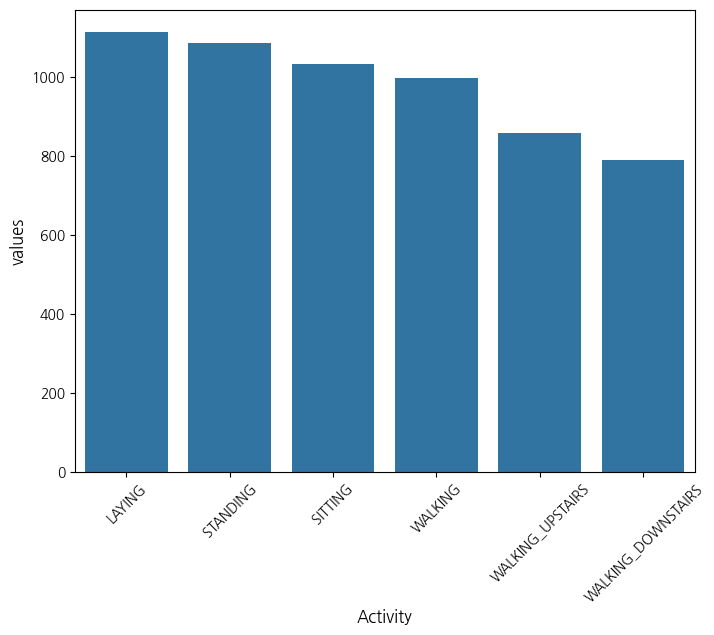

In [15]:
activity_counts = train['Activity'].value_counts()

plt.figure(figsize=(8, 6))
sns.barplot(x=activity_counts.index, y=activity_counts.values)

plt.xlabel('Activity', fontsize=12)
plt.ylabel('values', fontsize=12)

plt.xticks(rotation=45)  # 필요 시 x축 레이블 회전
plt.show()


## 3.미션1 : 데이터 분석1

수많은 feature들을 모두 살펴보는 것은 과도한 시간과 노력이 필요합니다. 그래서 여러분은 **선택과 집중**을 해야 합니다.
* 1) **트리 모델을 생성**한 후 **변수 중요도**를 구합니다.   
    * random forest 알고리즘 사용을 권장합니다.
* 2) **중요한 feature 상위 N개를 선정**하고, 이들을 대상으로 EDA 수행.
* 3) **각 feature 그룹별 중요도**도 파악해보며 EDA를 수행  
    * Feature 이름에는 계층구조를 담고 있습니다. 그렇다 보니 feature들을 적절하게 그룹으로 묶을 수 있습니다.
    * 참고로, feature 그룹의 중요도는 개별 feature 중요도의 합으로 계산할 수 있습니다.

### (1) 기본모델링 + 변수중요도 추출

* **세부 요구사항**
    - 모델링을 위한 기본 전처리를 수행합니다.
        - 주어진 데이터에서는 x, y로 나누고 train과 validation 분할 수행
    - 트리기반 알고리즘을 이용하여 모델링을 합니다.
        - 랜덤포레스트 권장 : 랜덤포레스트는 튜닝 없이 하이퍼파리미터의 기본값로도 적절한 성능의 모델을 생성할 수 있습니다.
    - 변수 중요도 추출
        - 사용자정의함수로 생성한 plot_feature_importance 을 이용
        - 변수중요도 파악및 결과 저장

#### 1) 데이터 전처리

In [16]:
train.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity
0,0.288508,-0.009196,-0.103362,-0.988986,-0.962797,-0.967422,-0.989000,-0.962596,-0.965650,-0.929747,...,-0.487737,-0.816696,-0.042494,-0.044218,0.307873,0.072790,-0.601120,0.331298,0.165163,STANDING
1,0.265757,-0.016576,-0.098163,-0.989551,-0.994636,-0.987435,-0.990189,-0.993870,-0.987558,-0.937337,...,-0.237820,-0.693515,-0.062899,0.388459,-0.765014,0.771524,0.345205,-0.769186,-0.147944,LAYING
2,0.278709,-0.014511,-0.108717,-0.997720,-0.981088,-0.994008,-0.997934,-0.982187,-0.995017,-0.942584,...,-0.535287,-0.829311,0.000265,-0.525022,-0.891875,0.021528,-0.833564,0.202434,-0.032755,STANDING
3,0.289795,-0.035536,-0.150354,-0.231727,-0.006412,-0.338117,-0.273557,0.014245,-0.347916,0.008288,...,-0.004012,-0.408956,-0.255125,0.612804,0.747381,-0.072944,-0.695819,0.287154,0.111388,WALKING
4,0.394807,0.034098,0.091229,0.088489,-0.106636,-0.388502,-0.010469,-0.109680,-0.346372,0.584131,...,-0.157832,-0.563437,-0.044344,-0.845268,-0.974650,-0.887846,-0.705029,0.264952,0.137758,WALKING_DOWNSTAIRS


In [17]:
x = train.drop(columns='Activity')
y = train['Activity']

In [18]:
x.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)"
0,0.288508,-0.009196,-0.103362,-0.988986,-0.962797,-0.967422,-0.989000,-0.962596,-0.965650,-0.929747,...,-0.032207,-0.487737,-0.816696,-0.042494,-0.044218,0.307873,0.072790,-0.601120,0.331298,0.165163
1,0.265757,-0.016576,-0.098163,-0.989551,-0.994636,-0.987435,-0.990189,-0.993870,-0.987558,-0.937337,...,-0.246705,-0.237820,-0.693515,-0.062899,0.388459,-0.765014,0.771524,0.345205,-0.769186,-0.147944
2,0.278709,-0.014511,-0.108717,-0.997720,-0.981088,-0.994008,-0.997934,-0.982187,-0.995017,-0.942584,...,0.388765,-0.535287,-0.829311,0.000265,-0.525022,-0.891875,0.021528,-0.833564,0.202434,-0.032755
3,0.289795,-0.035536,-0.150354,-0.231727,-0.006412,-0.338117,-0.273557,0.014245,-0.347916,0.008288,...,0.050888,-0.004012,-0.408956,-0.255125,0.612804,0.747381,-0.072944,-0.695819,0.287154,0.111388
4,0.394807,0.034098,0.091229,0.088489,-0.106636,-0.388502,-0.010469,-0.109680,-0.346372,0.584131,...,-0.013902,-0.157832,-0.563437,-0.044344,-0.845268,-0.974650,-0.887846,-0.705029,0.264952,0.137758


In [19]:
y.head()

,Activity
0,STANDING
1,LAYING
2,STANDING
3,WALKING
4,WALKING_DOWNSTAIRS


In [20]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2)

#### 2) 모델링

In [21]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report

In [22]:
model = RandomForestClassifier()
model.fit(x_train, y_train)
y_pred = model.predict(x_val)

print(confusion_matrix(y_val, y_pred))
print(classification_report(y_val, y_pred))

[[214   0   0   0   0   0]
 [  0 189  15   0   0   0]
 [  0   6 224   0   0   0]
 [  0   0   0 215   0   1]
 [  0   0   0   4 160   1]
 [  0   0   0   0   1 147]]
                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       214
           SITTING       0.97      0.93      0.95       204
          STANDING       0.94      0.97      0.96       230
           WALKING       0.98      1.00      0.99       216
WALKING_DOWNSTAIRS       0.99      0.97      0.98       165
  WALKING_UPSTAIRS       0.99      0.99      0.99       148

          accuracy                           0.98      1177
         macro avg       0.98      0.98      0.98      1177
      weighted avg       0.98      0.98      0.98      1177



- 전체 모델의 정확도 0.98

#### 3) 변수 중요도 추출

,feature_name,feature_importance
0,tGravityAcc-min()-X,0.037348
1,tGravityAcc-energy()-X,0.030690
2,tGravityAcc-max()-X,0.029054
3,tGravityAcc-mean()-Y,0.025103
4,tGravityAcc-min()-Y,0.024874
...,...,...
556,tBodyGyroJerk-mean()-Y,0.000097
557,"tBodyGyroJerk-arCoeff()-X,4",0.000095
558,"fBodyAcc-bandsEnergy()-49,56",0.000093
559,"tBodyAcc-arCoeff()-Y,1",0.000088


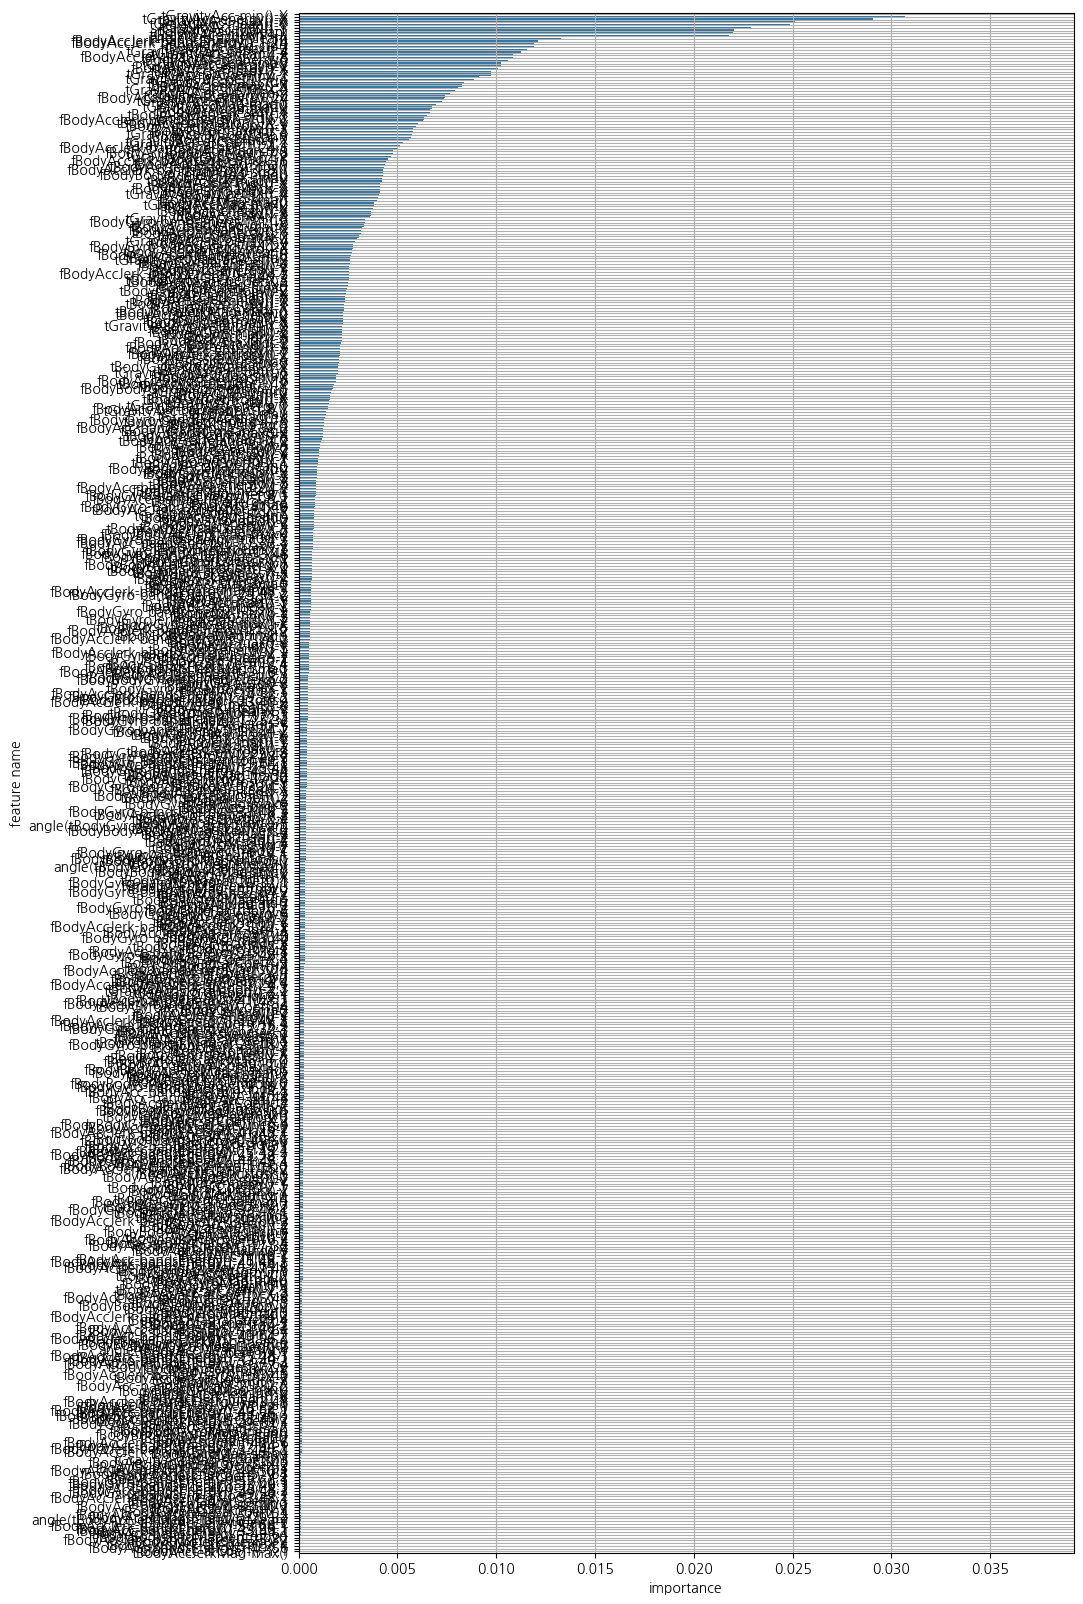

In [29]:
importances = model.feature_importances_
feature_names = x_train.columns

# 함수 호출 def plot_feature_importance(importance, names, result_only = False, topn = 'all')
fi = plot_feature_importance(importance=importances, names=feature_names, result_only=False)
fi
# gravityAcc 관련

### (2) 중요도 기반 feature 분석

* **세부 요구사항**
    - 상위 n, 하위 m 개의 변수를 선정
    - 선정된 변수(feature)와 target 간의 관계를 kdeplot으로 그리기

#### 1) 상위 5, 하위 5개 변수 선정

In [30]:
fi.head()

,feature_name,feature_importance
0,tGravityAcc-min()-X,0.037348
1,tGravityAcc-energy()-X,0.030690
2,tGravityAcc-max()-X,0.029054
3,tGravityAcc-mean()-Y,0.025103
4,tGravityAcc-min()-Y,0.024874


In [31]:
fi.tail()

,feature_name,feature_importance
556,tBodyGyroJerk-mean()-Y,0.000097
557,"tBodyGyroJerk-arCoeff()-X,4",0.000095
558,"fBodyAcc-bandsEnergy()-49,56",0.000093
559,"tBodyAcc-arCoeff()-Y,1",0.000088
560,tBodyAccJerkMag-max(),0.000081


#### 2) 상위 5개 변수에 대한 분석

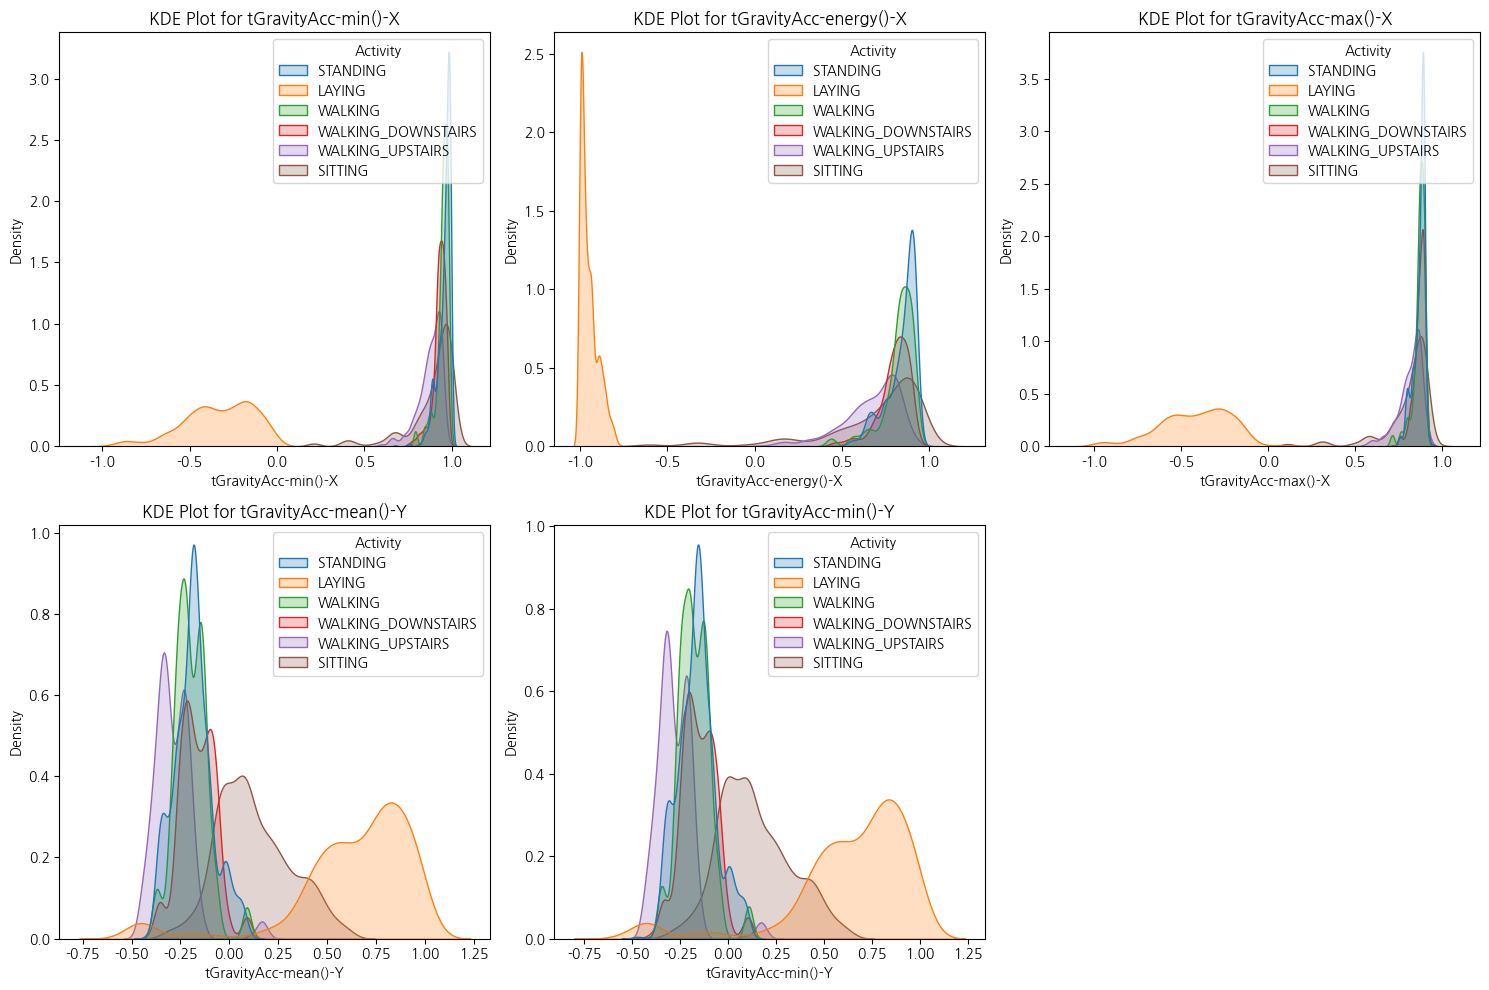

In [44]:
top_5_features = ['tGravityAcc-min()-X', 'tGravityAcc-energy()-X', 'tGravityAcc-max()-X', 'tGravityAcc-mean()-Y', 'tGravityAcc-min()-Y']

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, feature in enumerate(top_5_features):
    sns.kdeplot(data=train, x=feature, hue='Activity', fill=True, ax=axes[i])
    axes[i].set_title(f'KDE Plot for {feature}')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Density')

# 마지막 빈 플롯 숨기기
if len(top_5_features) < len(axes):
    for j in range(len(top_5_features), len(axes)):
        fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

#### 3) 하위 5개 변수에 대한 분석

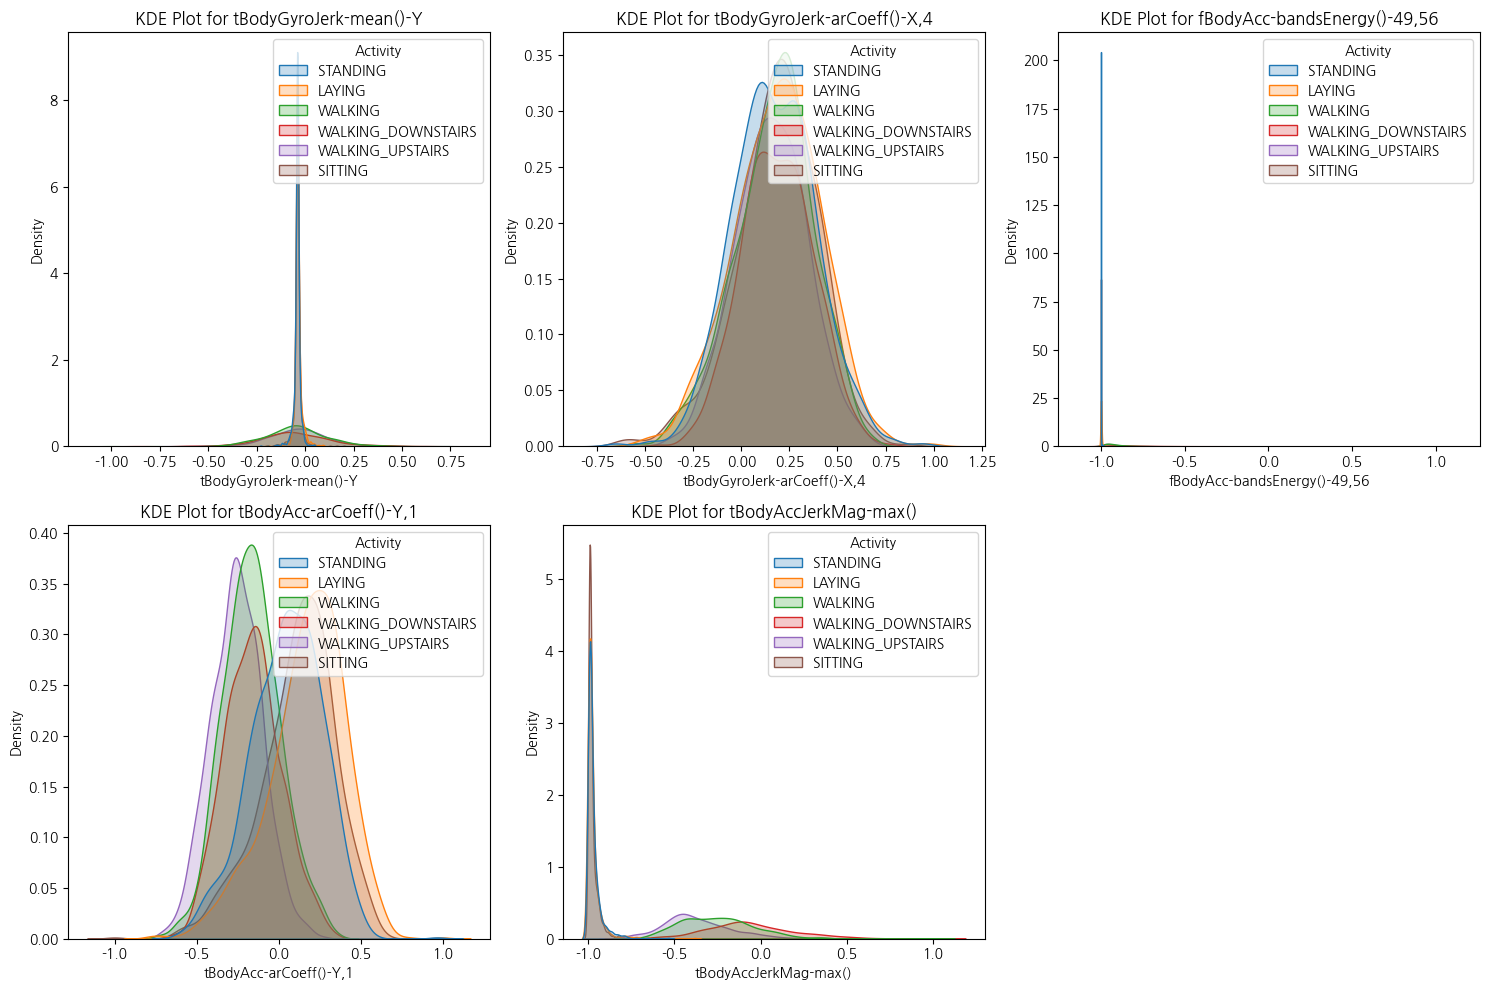

In [46]:
bottom_5_features = ['tBodyGyroJerk-mean()-Y', 'tBodyGyroJerk-arCoeff()-X,4', 'fBodyAcc-bandsEnergy()-49,56', 'tBodyAcc-arCoeff()-Y,1', 'tBodyAccJerkMag-max()']

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, feature in enumerate(bottom_5_features):
    sns.kdeplot(data=train, x=feature, hue='Activity', fill=True, ax=axes[i])
    axes[i].set_title(f'KDE Plot for {feature}')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Density')

# 마지막 빈 플롯 숨기기
if len(top_5_features) < len(axes):
    for j in range(len(top_5_features), len(axes)):
        fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

## 4.미션2 : 데이터 분석2

다음의 case에 맞게 feature 및 feature 그룹 중요도를 기반으로 탐색적 데이터 분석을 수행하시오.
* Target을 **정적/동적 행동**으로 구분
    * 6개의 행동은 2개의 그룹(정적행동, 동적행동)으로 나뉩니다.  
    * 어떤 feature(혹은 feature 그룹)이 2개 class 그룹(정적행동, 동적행동)를 구분하는데 중요한지를 찾아보고 탐색해봅시다.

### (1) 정적/동적 행동으로 구분하여 분석하기

* **세부 요구사항**
    - Target인 Activity를 is_dynamic 변수로 변경하시오.
        * 값 0 : STANDING, SITTING, LAYING
        * 값 1 : WALKING, WALKING_UPSTAIRS, WALKING_DOWNSTAIRS
    - is_dynamic을 예측하기 위한 기본 모델을 생성하시오.
        * x, is_dynamic을 이용하여 train과 validation으로 데이터 분할
        * 기본 모델링
    - is_dynamic 을 구분하는데 중요한 변수 상위 5를 분석하시오.
    - is_dynamic 을 구분하는데 중요한 변수 그룹을 분석하시오.
        * sensor별
        * sensor+agg 별


#### 1) is_dynamic 추가

#### 2) 기본모델 생성

In [47]:
# train dataset에서 Activity 변수를 is_dynamic 변수로 변경 -> activity 삭제 후 x,y 나누기
train['is_dynamic'] = train['Activity'].apply(lambda x: 1 if x in ['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS'] else 0)
train

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity,is_dynamic
0,0.288508,-0.009196,-0.103362,-0.988986,-0.962797,-0.967422,-0.989000,-0.962596,-0.965650,-0.929747,...,-0.816696,-0.042494,-0.044218,0.307873,0.072790,-0.601120,0.331298,0.165163,STANDING,0
1,0.265757,-0.016576,-0.098163,-0.989551,-0.994636,-0.987435,-0.990189,-0.993870,-0.987558,-0.937337,...,-0.693515,-0.062899,0.388459,-0.765014,0.771524,0.345205,-0.769186,-0.147944,LAYING,0
2,0.278709,-0.014511,-0.108717,-0.997720,-0.981088,-0.994008,-0.997934,-0.982187,-0.995017,-0.942584,...,-0.829311,0.000265,-0.525022,-0.891875,0.021528,-0.833564,0.202434,-0.032755,STANDING,0
3,0.289795,-0.035536,-0.150354,-0.231727,-0.006412,-0.338117,-0.273557,0.014245,-0.347916,0.008288,...,-0.408956,-0.255125,0.612804,0.747381,-0.072944,-0.695819,0.287154,0.111388,WALKING,1
4,0.394807,0.034098,0.091229,0.088489,-0.106636,-0.388502,-0.010469,-0.109680,-0.346372,0.584131,...,-0.563437,-0.044344,-0.845268,-0.974650,-0.887846,-0.705029,0.264952,0.137758,WALKING_DOWNSTAIRS,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5876,0.277194,-0.012389,-0.131974,-0.994046,-0.940578,-0.917337,-0.994261,-0.932830,-0.908088,-0.936219,...,-0.690363,-0.034888,-0.261437,-0.391477,-0.877612,-0.912365,0.114009,0.080146,SITTING,0
5877,0.191568,0.013328,-0.105174,-0.126969,-0.121729,-0.327480,-0.192523,-0.109923,-0.295286,0.078644,...,-0.879215,0.721718,0.623151,0.866858,-0.445660,-0.690278,0.303194,-0.044188,WALKING_UPSTAIRS,1
5878,0.267981,-0.018348,-0.107440,-0.991303,-0.989881,-0.990313,-0.992386,-0.988852,-0.991237,-0.936099,...,-0.886851,0.060173,0.228739,0.684400,-0.216665,0.620363,-0.437247,-0.571840,LAYING,0
5879,0.212787,-0.048130,-0.121001,-0.041373,0.052449,-0.585361,-0.100714,0.023353,-0.554707,0.219814,...,-0.053556,0.260880,0.551742,-0.943773,-0.862899,-0.718009,0.292856,0.024920,WALKING_UPSTAIRS,1


In [48]:
train = train.drop(columns='Activity')

x = train.drop(columns='is_dynamic')
print(x.head())
y = train['is_dynamic']
print(y.head())

   tBodyAcc-mean()-X  tBodyAcc-mean()-Y  tBodyAcc-mean()-Z  tBodyAcc-std()-X  \
0           0.288508          -0.009196          -0.103362         -0.988986   
1           0.265757          -0.016576          -0.098163         -0.989551   
2           0.278709          -0.014511          -0.108717         -0.997720   
3           0.289795          -0.035536          -0.150354         -0.231727   
4           0.394807           0.034098           0.091229          0.088489   

   tBodyAcc-std()-Y  tBodyAcc-std()-Z  tBodyAcc-mad()-X  tBodyAcc-mad()-Y  \
0         -0.962797         -0.967422         -0.989000         -0.962596   
1         -0.994636         -0.987435         -0.990189         -0.993870   
2         -0.981088         -0.994008         -0.997934         -0.982187   
3         -0.006412         -0.338117         -0.273557          0.014245   
4         -0.106636         -0.388502         -0.010469         -0.109680   

   tBodyAcc-mad()-Z  tBodyAcc-max()-X  ...  fBodyBodyGyr

In [52]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2)

print(x_train.shape, x_val.shape, y_train.shape, y_val.shape)

(4704, 561) (1177, 561) (4704,) (1177,)


In [56]:
model = RandomForestClassifier()
model.fit(x_train, y_train)
y_pred = model.predict(x_val)

In [57]:
print(confusion_matrix(y_val, y_pred))
print(classification_report(y_val, y_pred))

[[624   1]
 [  0 552]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       625
           1       1.00      1.00      1.00       552

    accuracy                           1.00      1177
   macro avg       1.00      1.00      1.00      1177
weighted avg       1.00      1.00      1.00      1177



#### 3) 변수중요도 상위 5개 분석

,feature_name,feature_importance
0,fBodyAccJerk-max()-X,0.060045
1,"fBodyAccJerk-bandsEnergy()-1,24",0.050163
2,fBodyAccJerk-entropy()-X,0.050043
3,tBodyAccJerk-energy()-X,0.050034
4,"fBodyAccJerk-bandsEnergy()-1,16",0.040069
...,...,...
556,tBodyGyroMag-mad(),0.000000
557,tBodyGyroMag-std(),0.000000
558,tBodyAccJerkMag-arCoeff()4,0.000000
559,tBodyAccJerkMag-arCoeff()3,0.000000


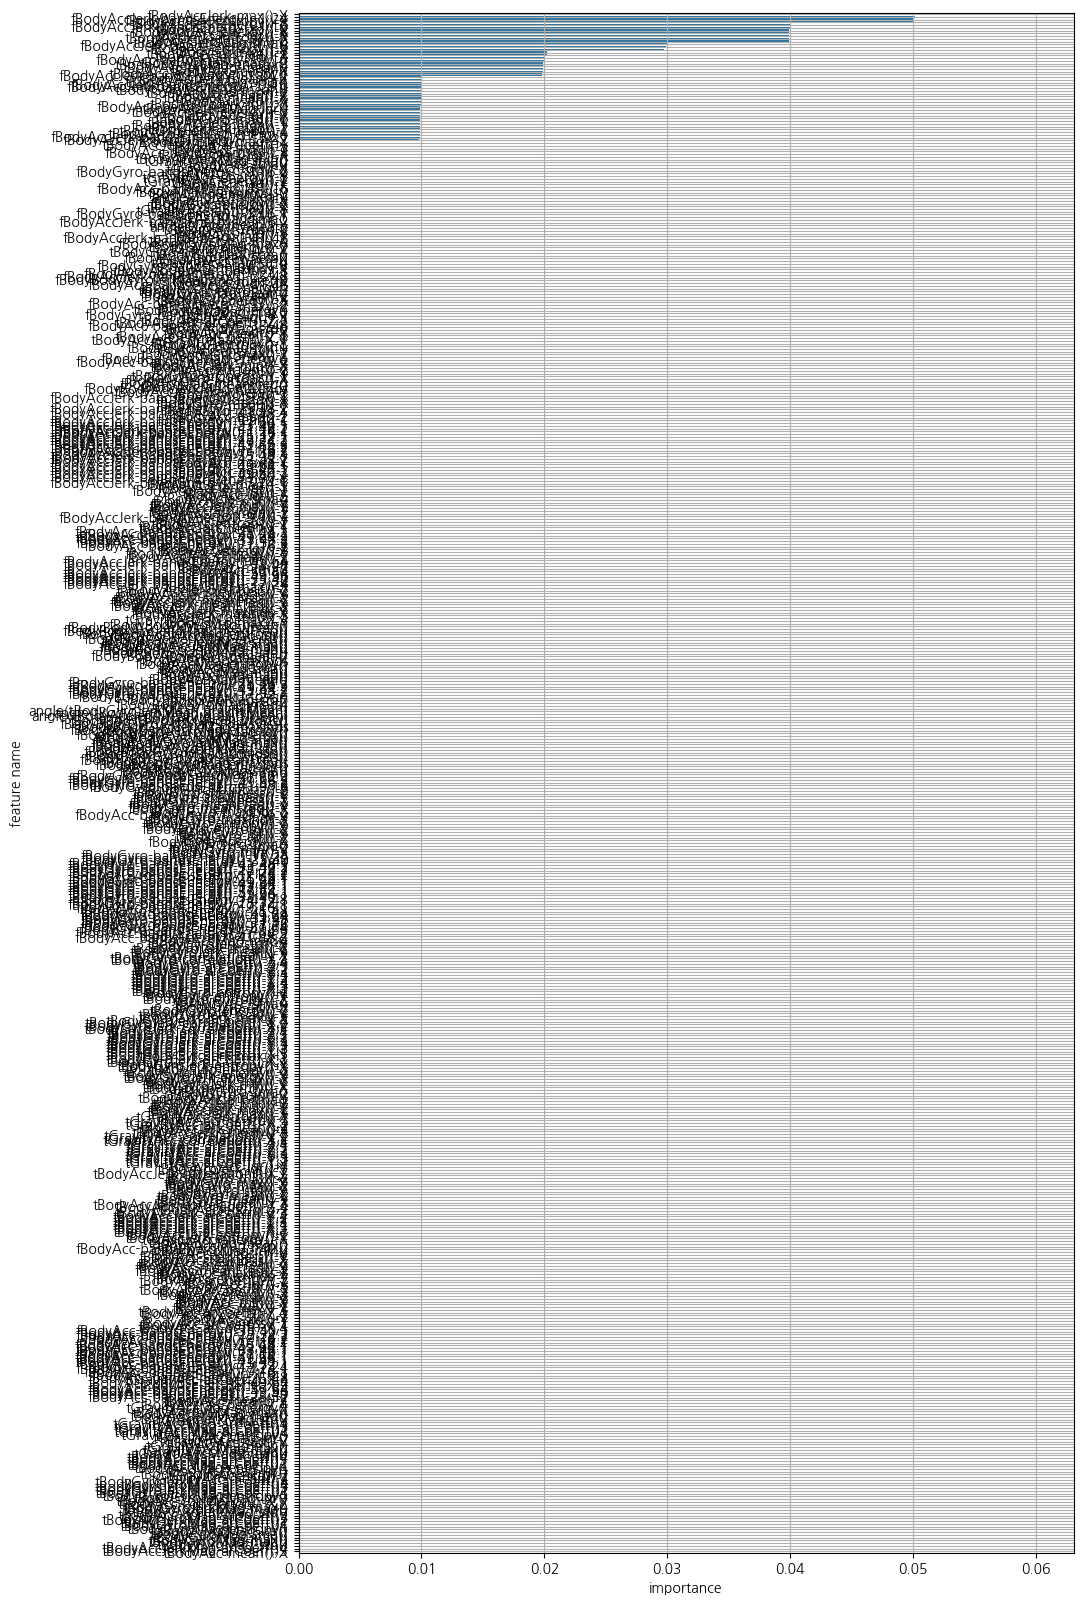

In [58]:
importances = model.feature_importances_
feature_names = x_train.columns

fi_d = plot_feature_importance(importance=importances, names=feature_names, result_only=False)
fi_d

In [59]:
fi_d.head()
# 퓨리에 변환 거친& 가속도 변화비율, 에너지 밴드 가속도

,feature_name,feature_importance
0,fBodyAccJerk-max()-X,0.060045
1,"fBodyAccJerk-bandsEnergy()-1,24",0.050163
2,fBodyAccJerk-entropy()-X,0.050043
3,tBodyAccJerk-energy()-X,0.050034
4,"fBodyAccJerk-bandsEnergy()-1,16",0.040069


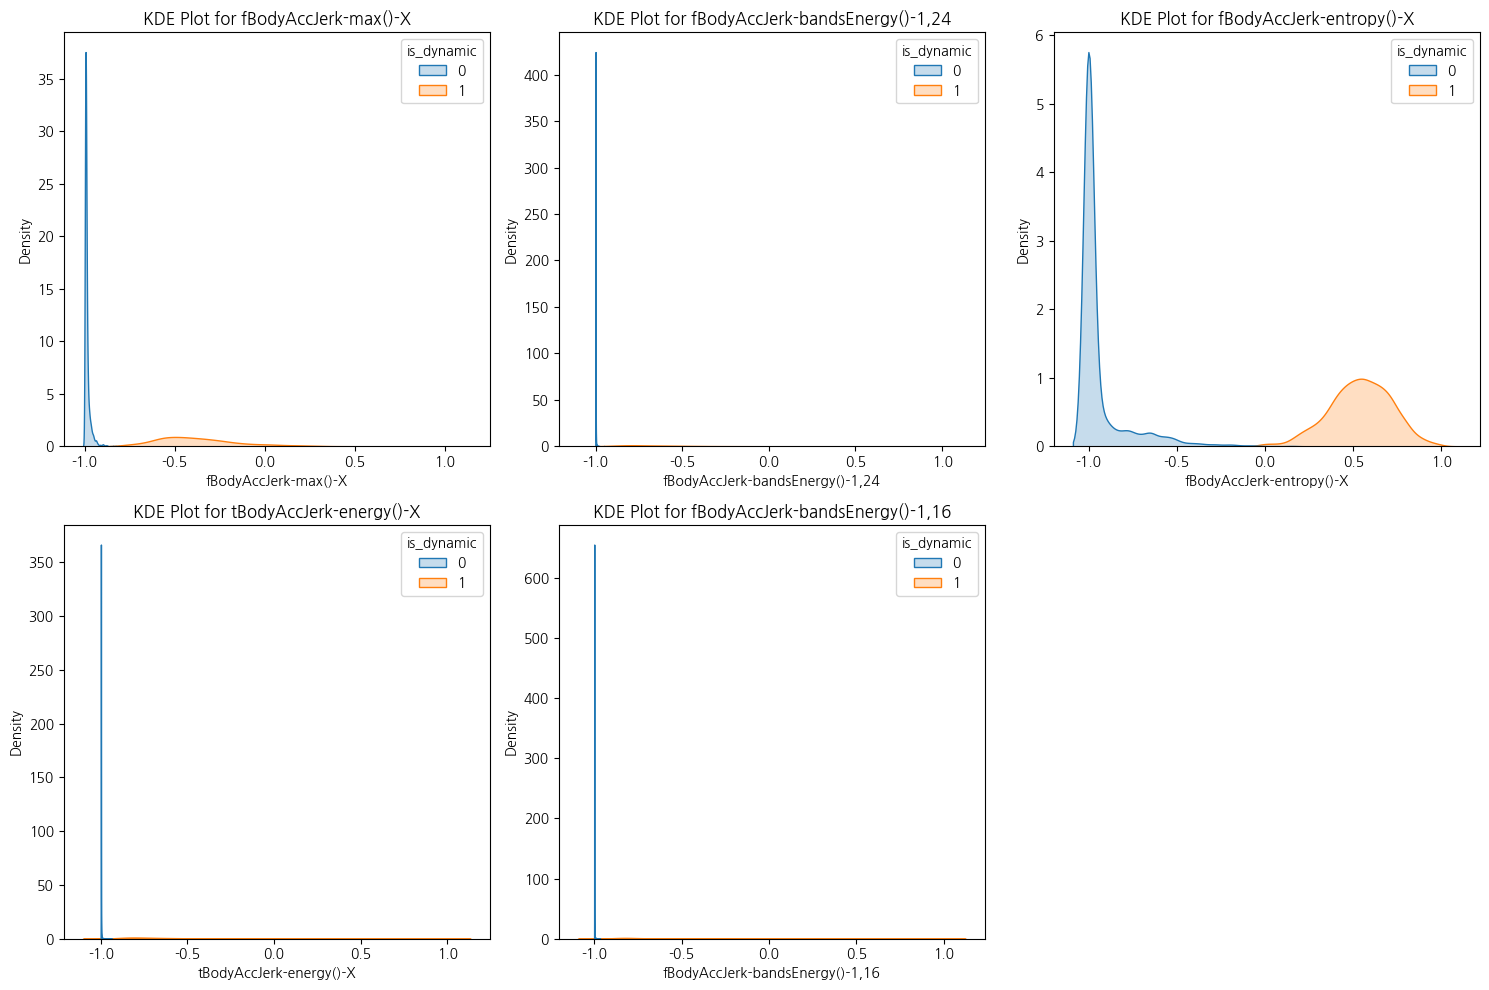

In [61]:
top_5_features = ['fBodyAccJerk-max()-X', 'fBodyAccJerk-bandsEnergy()-1,24', 'fBodyAccJerk-entropy()-X', 'tBodyAccJerk-energy()-X', 'fBodyAccJerk-bandsEnergy()-1,16']

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, feature in enumerate(top_5_features):
    sns.kdeplot(data=x, x=feature, hue=y, fill=True, ax=axes[i])
    axes[i].set_title(f'KDE Plot for {feature}')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Density')

# 마지막 빈 플롯 숨기기
if len(top_5_features) < len(axes):
    for j in range(len(top_5_features), len(axes)):
        fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

#### sensor 별 중요도 시각화

Sensor: accelerometer, Total Importance: 0.8202238720136862
Sensor: gyroscope, Total Importance: 0.17953189102728964


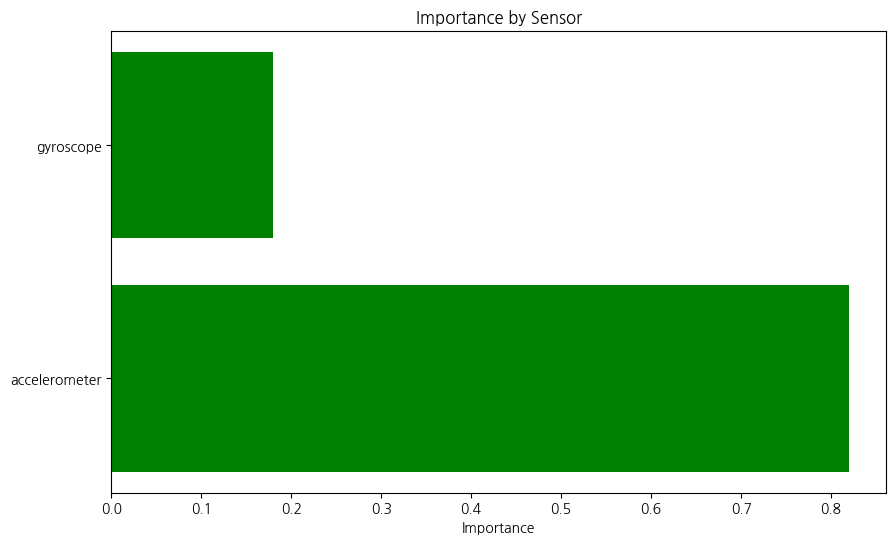

In [ ]:
sensor_importances = {'accelerometer': 0, 'gyroscope': 0}

# 변수별 중요도 계산
for col in x_train.columns:
    if 'Acc' in col:
        sensor_importances['accelerometer'] += importances[x_train.columns.get_loc(col)]
    elif 'Gyro' in col:
        sensor_importances['gyroscope'] += importances[x_train.columns.get_loc(col)]

# sensor별 중요도 출력
for sensor, importance in sensor_importances.items():
    print(f"Sensor: {sensor}, Total Importance: {importance}")

# 시각화
sensors, importances = zip(*sensor_importances.items())
plt.figure(figsize=(10, 6))
plt.barh(sensors, importances, color='green')
plt.xlabel("Importance")
plt.title("Importance by Sensor")
plt.show()

#### sensor + aggregation 별 중요도 시각화

Sensor+Aggregation: Acc_entropy(), Total Importance: 0.13985660120188217
Sensor+Aggregation: Acc_energy(), Total Importance: 0.1298286243936993
Sensor+Aggregation: Acc_std(), Total Importance: 0.08028001632244143
Sensor+Aggregation: Gyro_iqr(), Total Importance: 0.07953807884636477
Sensor+Aggregation: Acc_mad(), Total Importance: 0.07021797893629787
Sensor+Aggregation: Acc_max(), Total Importance: 0.07006823689975823
Sensor+Aggregation: Acc_iqr(), Total Importance: 0.05986202455657655
Sensor+Aggregation: Acc_sma(), Total Importance: 0.04005594878416195
Sensor+Aggregation: Acc_mean(), Total Importance: 0.039999893390015286
Sensor+Aggregation: Gyro_mad(), Total Importance: 0.039718275617312025
Sensor+Aggregation: Gyro_sma(), Total Importance: 0.010009304218870392
Sensor+Aggregation: Gyro_energy(), Total Importance: 0.010004533570841379
Sensor+Aggregation: Gyro_mean(), Total Importance: 0.00996571308520164
Sensor+Aggregation: Gyro_entropy(), Total Importance: 0.009888161230697738
Sensor+A

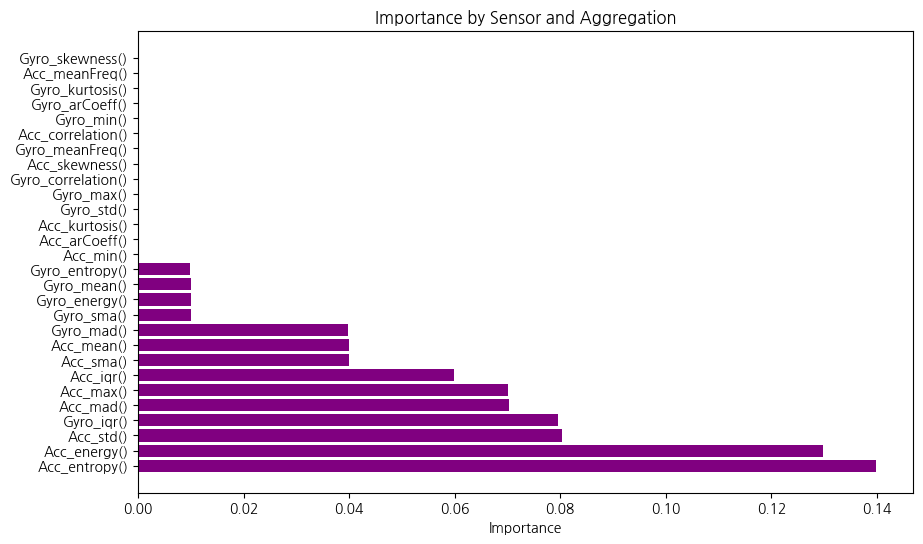

In [65]:
# 센서 별로 먼저 묶은 다음 -> 각 센서의 집계 함수 별로 묶기 (전체)
sensor_types = ['Acc', 'Gyro']
agg_functions = ['mean()', 'std()', 'mad()', 'max()', 'min()', 'sma()', 'energy()',
                 'iqr()', 'entropy()', 'arCoeff()', 'correlation()', 'maxInds()',
                 'meanFreq()', 'skewness()', 'kurtosis()']

sensor_agg_importances = {}

for sensor in sensor_types:
    # 1단계: 센서별로 먼저 변수 묶기
    sensor_cols = [col for col in x_train.columns if sensor in col]

    # 각 센서에 대해 집계 함수별로 중요도 합산
    for agg in agg_functions:
        sensor_agg_cols = [col for col in sensor_cols if agg in col]
        if sensor_agg_cols:
            # 해당 센서와 집계 함수에 속한 변수들의 중요도 합산
            sensor_agg_importance = importances[[x_train.columns.get_loc(col) for col in sensor_agg_cols]].sum()
            sensor_agg_importances[f"{sensor}_{agg}"] = sensor_agg_importance

# sensor+aggregation별 중요도 내림차순 출력
sensor_agg_importances = sorted(sensor_agg_importances.items(), key=lambda x: x[1], reverse=True)
for sensor_agg, importance in sensor_agg_importances:
    print(f"Sensor+Aggregation: {sensor_agg}, Total Importance: {importance}")

# 시각화
sensor_aggs, importances = zip(*sensor_agg_importances)
plt.figure(figsize=(10, 6))
plt.barh(sensor_aggs, importances, color='purple')
plt.xlabel("Importance")
plt.title("Importance by Sensor and Aggregation")
plt.show()

- 상위 5개 변수일수록 행동 예측을 잘함

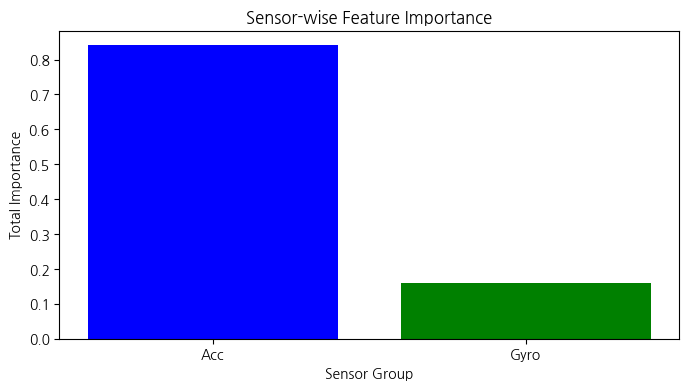

In [62]:
# Sensor별 중요도 시각화
sensor_groups = {
    'Acc': [col for col in x_train.columns if 'Acc' in col],
    'Gyro': [col for col in x_train.columns if 'Gyro' in col]
}

group_importances = {}
for group_name, group_cols in sensor_groups.items():
    group_importance = importances[[x_train.columns.get_loc(col) for col in group_cols]].sum()
    group_importances[group_name] = group_importance

plt.figure(figsize=(8, 4))
plt.bar(group_importances.keys(), group_importances.values(), color=['blue', 'green'])
plt.title("Sensor-wise Feature Importance")
plt.xlabel("Sensor Group")
plt.ylabel("Total Importance")
plt.show()

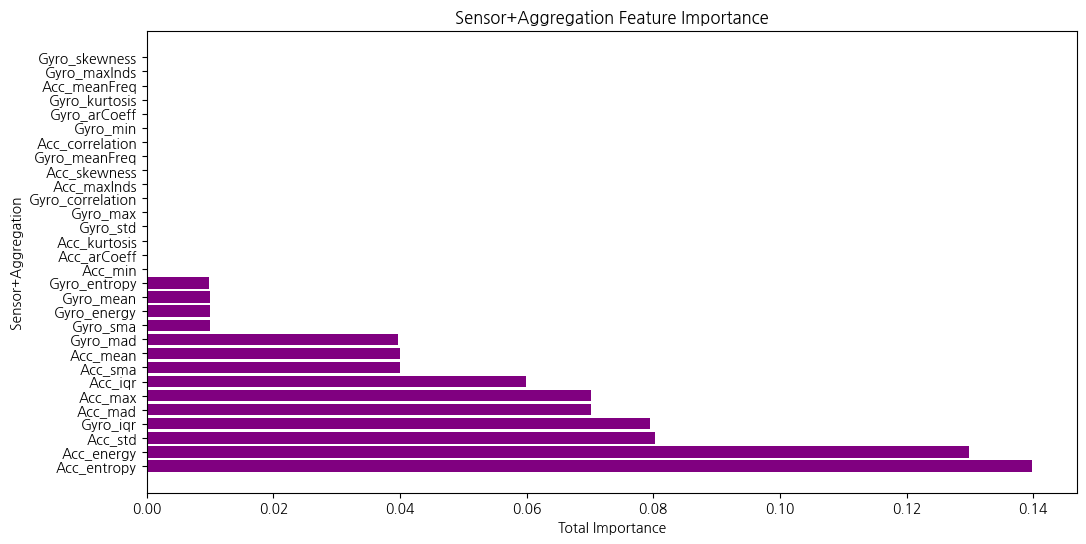

In [63]:
# Sensor + Aggregation별 중요도 시각화
sensor_types = ['Acc', 'Gyro']
agg_functions = ['mean', 'std', 'mad', 'max', 'min', 'sma', 'energy',
                 'iqr', 'entropy', 'arCoeff', 'correlation', 'maxInds',
                 'meanFreq', 'skewness', 'kurtosis']

sensor_agg_importances = {}
for sensor in sensor_types:
    for agg in agg_functions:
        sensor_agg_cols = [col for col in x_train.columns if sensor in col and agg in col]
        if sensor_agg_cols:
            sensor_agg_importance = importances[[x_train.columns.get_loc(col) for col in sensor_agg_cols]].sum()
            sensor_agg_importances[f"{sensor}_{agg}"] = sensor_agg_importance

sorted_importances = sorted(sensor_agg_importances.items(), key=lambda item: item[1], reverse=True)
sensor_aggs, importances_values = zip(*sorted_importances)

plt.figure(figsize=(12, 6))
plt.barh(sensor_aggs, importances_values, color='purple')
plt.title("Sensor+Aggregation Feature Importance")
plt.xlabel("Total Importance")
plt.ylabel("Sensor+Aggregation")
plt.show()

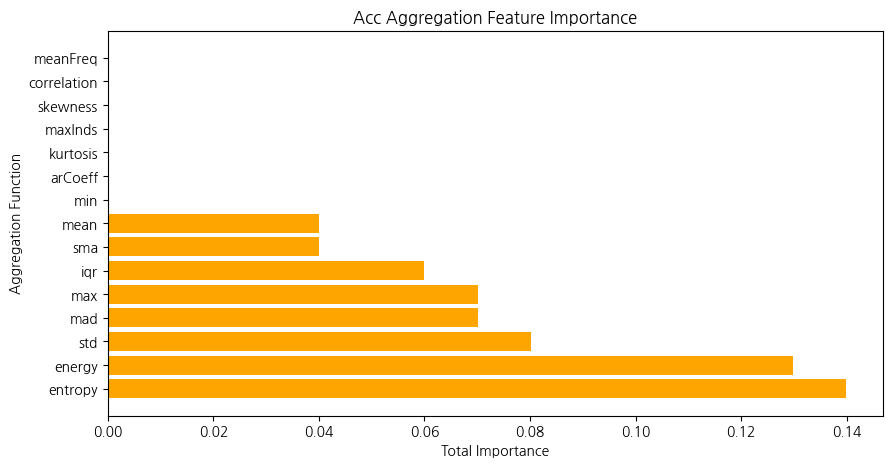

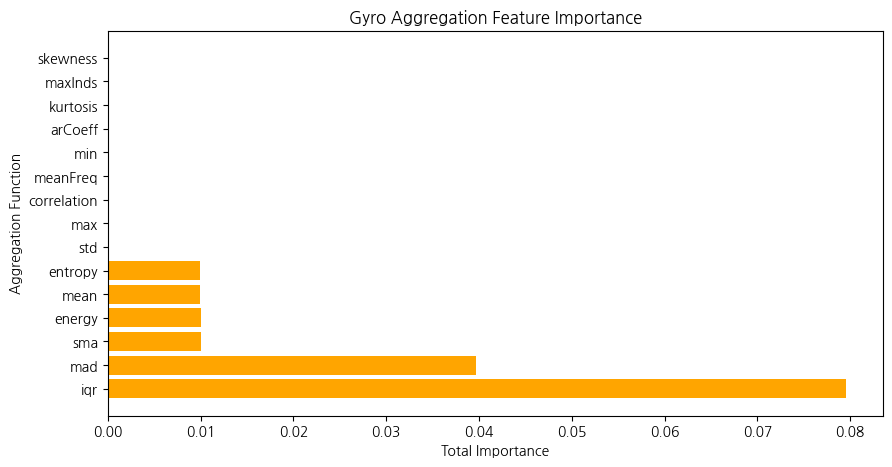

In [64]:
# 센서별 Aggregation 중요도 시각화
sensor_agg_importances = {}
for sensor in sensor_types:
    sensor_agg_importances[sensor] = {}
    for agg in agg_functions:
        sensor_agg_cols = [col for col in x_train.columns if sensor in col and agg in col]
        if sensor_agg_cols:
            agg_importance = importances[[x_train.columns.get_loc(col) for col in sensor_agg_cols]].sum()
            sensor_agg_importances[sensor][agg] = agg_importance

for sensor in sensor_types:
    agg_importances = sensor_agg_importances[sensor]
    sorted_agg_importances = sorted(agg_importances.items(), key=lambda item: item[1], reverse=True)
    aggs, importances_values = zip(*sorted_agg_importances)

    plt.figure(figsize=(10, 5))
    plt.barh(aggs, importances_values, color='orange')
    plt.title(f"{sensor} Aggregation Feature Importance")
    plt.xlabel("Total Importance")
    plt.ylabel("Aggregation Function")
    plt.show()